# Run level 2A, 2B and 3 pipelines on MRS data using jwst.pipeline classes

### by Patrick Kavanagh (DIAS, Ireland) August 18th 2017

This notebook demonstrates the execution of the level 2A and 2B pipelines for MRS data in Python using the jwst.pipeline classes.

For a description of the pipeline classes see:

http://ssb.stsci.edu/doc/jwst_dev/jwst/pipeline/index.html

The files used in this notebook is a MIRISim simulation of a point source with a 300 K blackbody plus emission lines spectrum

The simulated observation is a four-point dither on the source with the channels 1 and 2, and the SHORT disperser. 

#### Imports

In [1]:
import os, glob, shutil

import numpy as np
from astropy.io import fits
from matplotlib.colors import LogNorm
import matplotlib.pyplot as plt
from subprocess import call

from jwst import datamodels

%matplotlib inline
# %matplotlib notebook # if you want interactive plots

#### Set input file:

In [2]:
# set input filenames and directory. In this example, the files are located in a folder called 'MRS_demo_data'
input_dir = 'MRS_demo_data'
input_files = glob.glob(os.path.join(input_dir,'*.fits'))

# set the output directory name
output_dir = input_dir + '_pipelined'

# if the output directory exists, delete it
if os.path.exists(output_dir): shutil.rmtree(output_dir)

# create the output directory
os.mkdir(output_dir)

#### print some information about the input files. We will just look at the first file

In [3]:
# print some info on input file
with fits.open(input_files[0]) as hdulist:
    
    if hdulist[0].header['ORIGIN'] == 'STScI':
        # specific information on instrument/exposure
        identifier = hdulist[0].header['OBS_ID']
        detector = hdulist[0].header['DETECTOR']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        channel = hdulist[0].header['CHANNEL']
        band = hdulist[0].header['BAND']
        print "ID\t\t\t\t Detector\t nInts\t nGrps\t rdPatt\t subAr\t chan.\t band"
        print "--------------------------------------------------------------------------------------------------"
        print "%s\t %s\t %d\t %s\t %s\t %s\t %s\t %s" % (identifier,detector,nInts,nGroups,readPatt,subArr,channel,band)
        print "\n\n"
        
    else:
        # specific information on instrument/exposure
        detector = hdulist[0].header['DETECTOR']
        nInts = hdulist[0].header['NINTS']
        nGroups = hdulist[0].header['NGROUPS']
        readPatt = hdulist[0].header['READPATT']
        expTime = hdulist[0].header['EFFEXPTM']
        subArr = hdulist[0].header['SUBARRAY']
        channel = hdulist[0].header['CHANNEL']
        band = hdulist[0].header['BAND']
        print "ID\t Detector\t nInts\t nGrps\t rdPatt\t chan.\t band"
        print "--------------------------------------------------------------------------------------------------"
        print "MIRISim\t %s\t %d\t %s\t %s\t %s\t %s" % (detector,nInts,nGroups,readPatt,channel,band)
        print "\n\n"

    # fits extension table
    hdulist.info()

ID	 Detector	 nInts	 nGrps	 rdPatt	 chan.	 band
--------------------------------------------------------------------------------------------------
MIRISim	 MIRIFUSHORT	 2	 50	 FAST	 12	 SHORT



Filename: MRS_demo_data/det_image_seq1_MIRIFUSHORT_12SHORTexp1.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     148   ()      
  1  SCI           1 ImageHDU        14   (1032, 1024, 50, 2)   float32   
  2  REFOUT        1 ImageHDU        14   (258, 1024, 50, 2)   float32   
  3  PIXELDQ       1 ImageHDU        10   (1032, 1024)   int32 (rescales to uint32)   
  4  PIXELDQ_DEF    1 BinTableHDU     17   29R x 4C   [J, J, 40A, 128A]   
  5  ASDF          1 ImageHDU         7   (533679068,)   uint8   


#### show the last frame of the first integration for each file

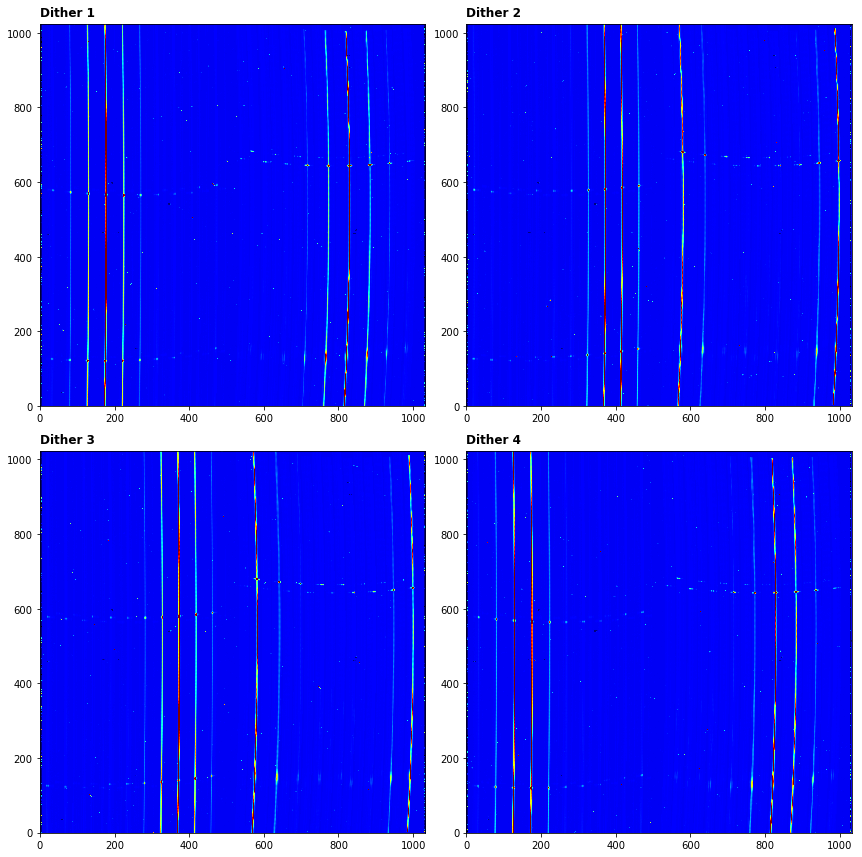

In [4]:
fig, axs = plt.subplots(2, 2, figsize=(12, 12))
axs = axs.ravel()

i = 0
for input_file in input_files:
    # open the input image as a jwst data model
    with datamodels.open(input_file) as in_dm:

        dith_num = i+1
        axs[i].imshow(in_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=9e3,vmax=3e4))
        axs[i].annotate('Dither %d' % dith_num, xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[i].set_facecolor('black')
        i += 1

plt.tight_layout()
plt.show()

### Level 2A pipeline (ramps-to-slopes)

#### import the level 2A pipeline class and print description

In [5]:
from jwst.pipeline import SloperPipeline
print SloperPipeline.__doc__



    SloperPipeline: Apply all calibration steps to raw JWST
    ramps to produce a 2-D slope product. Included steps are:
    group_scale, dq_init, saturation, ipc, superbias, refpix, rscd,
    lastframe, linearity, dark_current, persistence, jump detection,
    and ramp_fit.

    


For MIRI, the steps in order are: dq_init, saturation, linearity, RSCD, lastframe, dark_current, refpix, jump, ramp_fitting

#### run pipeline
We pass the level 1B files (demo data). The output level 2A files will be saved in the output_dir as '*_rate.fits'

NOTE: As dark current was switched off in the MIRISim simulations that produced the demo data, we will skip the dark_current step in the call to the SloperPipeline

In [6]:
for input_file in input_files:
    dm_2A = SloperPipeline.call(input_file, save_results=True, output_dir=output_dir, steps={'dark_current':{'skip':True}})


2017-08-26 16:03:00,019 - stpipe.SloperPipeline - INFO - SloperPipeline instance created.
2017-08-26 16:03:00,021 - stpipe.SloperPipeline.group_scale - INFO - GroupScaleStep instance created.
2017-08-26 16:03:00,023 - stpipe.SloperPipeline.saturation - INFO - SaturationStep instance created.
2017-08-26 16:03:00,025 - stpipe.SloperPipeline.rscd - INFO - RSCD_Step instance created.
2017-08-26 16:03:00,027 - stpipe.SloperPipeline.ipc - INFO - IPCStep instance created.
2017-08-26 16:03:00,033 - stpipe.SloperPipeline.ramp_fit - INFO - RampFitStep instance created.
2017-08-26 16:03:00,037 - stpipe.SloperPipeline.linearity - INFO - LinearityStep instance created.
2017-08-26 16:03:00,038 - stpipe.SloperPipeline.jump - INFO - JumpStep instance created.
2017-08-26 16:03:00,041 - stpipe.SloperPipeline.refpix - INFO - RefPixStep instance created.
2017-08-26 16:03:00,042 - stpipe.SloperPipeline.lastframe - INFO - LastFrameStep instance created.
2017-08-26 16:03:00,045 - stpipe.SloperPipeline.dq_ini

#### Quick check of the pipeline steps applied in the output. We'll look at the first dither:

In [7]:
level2A_files = glob.glob(os.path.join(output_dir,'*_rate.fits'))

with datamodels.open(level2A_files[0]) as dm:
    # check the calibration step information
    print'Check step information status:'
    print 'dq_init: %s' % dm.meta.cal_step.dq_init
    print 'saturation: %s' % dm.meta.cal_step.saturation
    print 'linearity: %s' % dm.meta.cal_step.linearity
    print 'rscd: %s' % dm.meta.cal_step.rscd
    print 'lastframe: %s' % dm.meta.cal_step.lastframe
    print 'dark_current: %s' % dm.meta.cal_step.dark_sub
    print 'refpix: %s' % dm.meta.cal_step.refpix
    print 'jump: %s' % dm.meta.cal_step.jump
    print 'ramp_fit: %s' % dm.meta.cal_step.ramp_fit

Check step information status:
dq_init: COMPLETE
saturation: COMPLETE
linearity: COMPLETE
rscd: COMPLETE
lastframe: COMPLETE
dark_current: None
refpix: COMPLETE
jump: COMPLETE
ramp_fit: COMPLETE


### Level 2B pipeline

#### import the level 2B pipeline class and print description

In [8]:
from jwst.pipeline import Spec2Pipeline
print Spec2Pipeline.__doc__


    Spec2Pipeline: Processes JWST spectroscopic exposures from Level 2a to 2b.
    Accepts a single exposure or an association as input.

    Included steps are:
    assign_wcs, background subtraction, NIRSpec MSA imprint subtraction,
    NIRSpec MSA bad shutter flagging, 2-D subwindow extraction, flat field,
    source type decision, straylight, fringe, pathloss, photom, resample_spec,
    cube_build, and extract_1d.
    


For the MRS, the level 2B steps in order are: assign_wcs, bkg_subtract, flat_field, srctype, straylight, fringe, photom, cube_build, extract_1d

Note that bkg_subtract requires an association so will not be applied to single files. 

#### run pipeline
We pass the level 2A files. The output level 2B files will be saved in the output_dir as '*_cal.fits'. A cube and 1D spectrum is also saved (see below). 

Note that since MIRISim does not add straylight, we can skip the straylight correction step.

In [9]:
for f in level2A_files:
    dm_2B = Spec2Pipeline.call(f, save_results=True, output_dir=output_dir, steps={'straylight':{'skip':True},
                                                                                       'cube_build':{'save_results':True},
                                                                                       'extract_1d':{'save_results':True}})


2017-08-26 16:23:15,126 - stpipe.Spec2Pipeline - INFO - Spec2Pipeline instance created.
2017-08-26 16:23:15,128 - stpipe.Spec2Pipeline.pathloss - INFO - PathLossStep instance created.
2017-08-26 16:23:15,131 - stpipe.Spec2Pipeline.assign_wcs - INFO - AssignWcsStep instance created.
2017-08-26 16:23:15,133 - stpipe.Spec2Pipeline.msa_flagging - INFO - MSAFlagOpenStep instance created.
2017-08-26 16:23:15,135 - stpipe.Spec2Pipeline.imprint_subtract - INFO - ImprintStep instance created.
2017-08-26 16:23:15,137 - stpipe.Spec2Pipeline.photom - INFO - PhotomStep instance created.
2017-08-26 16:23:15,139 - stpipe.Spec2Pipeline.resample_spec - INFO - ResampleSpecStep instance created.
2017-08-26 16:23:15,142 - stpipe.Spec2Pipeline.cube_build - INFO - CubeBuildStep instance created.
2017-08-26 16:23:15,144 - stpipe.Spec2Pipeline.straylight - INFO - StraylightStep instance created.
2017-08-26 16:23:15,146 - stpipe.Spec2Pipeline.bkg_subtract - INFO - BackgroundStep instance created.
2017-08-26 16

### check of output

The level 2B pipeline for the MRS produces three files for each input:

_cal.fits - the calibrated level 2B file

_s3d.fits - the cube

_x1d.fits - the 1d spectrum

We can have a look at each of these for the first dither

In [10]:
# set the output file names
level2B_files = glob.glob(os.path.join(output_dir,'*_cal.fits'))
cube_files = glob.glob(os.path.join(output_dir,'*_s3d.fits'))
spec_files = glob.glob(os.path.join(output_dir,'*_x1d.fits'))

#### level 2B file

In [11]:
with datamodels.open(level2B_files[0]) as dm:
    # check the calibration step information
    print'Check step information status:'
    print 'assign_wcs: %s' % dm.meta.cal_step.assign_wcs
    print 'flat_field: %s' % dm.meta.cal_step.flat_field
    print 'srctype: %s' % dm.meta.cal_step.srctype
    print 'fringe: %s' % dm.meta.cal_step.fringe
    print 'photom: %s' % dm.meta.cal_step.photom


Check step information status:
assign_wcs: COMPLETE
flat_field: COMPLETE
srctype: COMPLETE
fringe: COMPLETE
photom: COMPLETE


#### Look at level 1B and calibrated level 2B image. We'll look at the first dither only

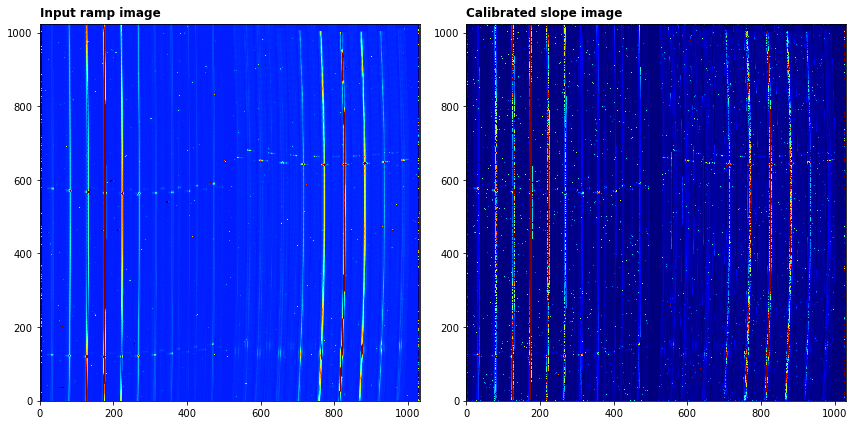

In [12]:
# open the input image as a jwst data model
with datamodels.open(input_files[0]) as in_dm:
    with datamodels.open(level2B_files[0]) as out_dm:
        
        # plot--------------------------------------
        # show the input ramp image and the calibrated
        # slope image. Note the user may have to adjust
        # the scale parameters
        fig, axs = plt.subplots(1, 2, figsize=(12, 6))

        # sum the groups in the first integration of the input ramp image and plot
        axs[0].imshow(in_dm.data[0,-1,:,:], cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=9e3,vmax=2e4))
        axs[0].annotate('Input ramp image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[0].set_facecolor('black')
        axs[1].imshow(out_dm.data, cmap='jet', interpolation='nearest', origin='lower', vmin=0, vmax=200)
        axs[1].annotate('Calibrated slope image', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
        axs[1].set_facecolor('black')

        plt.tight_layout()
        plt.show()

#### Look at cube file. We'll look at the first dither only

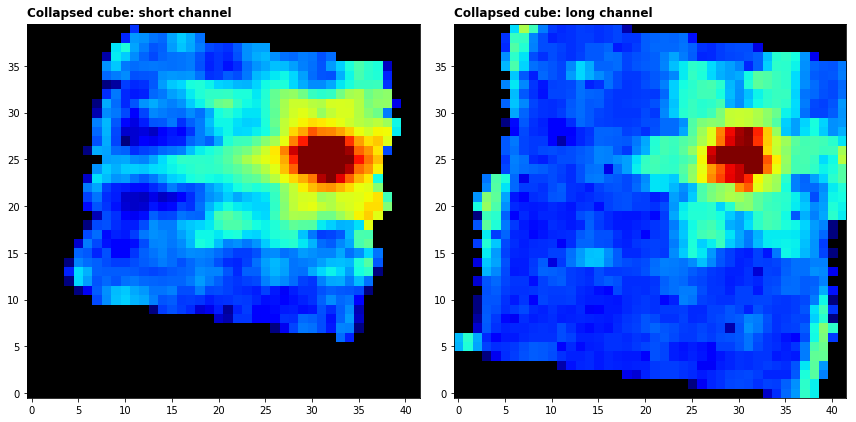

In [13]:
# open the cube as a jwst data model
cube_dm = datamodels.open(cube_files[0])
    
# plot--------------------------------------
# sum some of the the frames in each channel
# Note the user may have to adjust the scaling
# parameters
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(np.sum(cube_dm.data[100:300], axis=0), cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=100,vmax=5e4))
axs[0].annotate('Collapsed cube: short channel', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[0].set_facecolor('black')
axs[1].imshow(np.sum(cube_dm.data[1200:1400], axis=0), cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=400,vmax=5e4))
axs[1].annotate('Collapsed cube: long channel', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[1].set_facecolor('black')

plt.tight_layout()
plt.show()

#### 1D spectrum

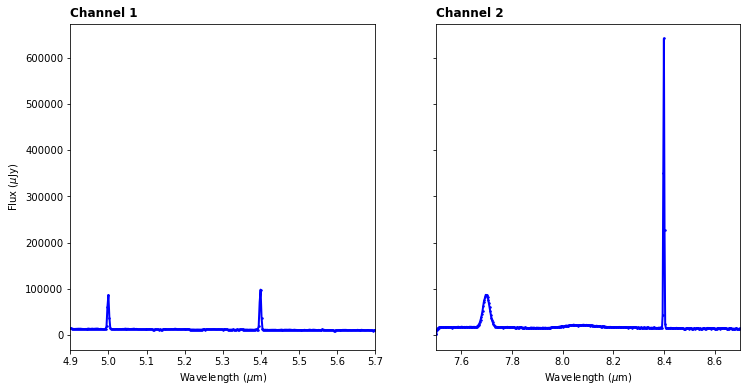

In [14]:
from jwst.datamodels import SpecModel

# open the spectrum as a jwst data model
with SpecModel(spec_files[0]) as spec_dm:
    # plot--------------------------------------
    # simple XY plot of the spectrum
    fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

    # plot the spectrum in the channel 2 wavelength range
    spaxel_area = cube_dm.meta.wcsinfo.cdelt1 * cube_dm.meta.wcsinfo.cdelt2 * 3600**2
    axs[0].plot(spec_dm.spec_table['WAVELENGTH'], spec_dm.spec_table['FLUX'] * spaxel_area, c='b', marker='.', markersize=3, linestyle='-', linewidth=2)
    axs[0].set_ylabel(r'Flux (mJy)')
    axs[0].set_xlabel(r'Wavelength ($\mu$m)')
    axs[0].set_xlim(4.9,5.7)
    #axs[0].set_ylim(0,6000)
    axs[0].annotate('Channel 1', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')

    
    axs[1].plot(spec_dm.spec_table['WAVELENGTH'], spec_dm.spec_table['FLUX'] * spaxel_area, c='b', marker='.', markersize=3, linestyle='-', linewidth=2)
    axs[1].set_xlabel(r'Wavelength (mJy)')
    axs[1].set_xlim(7.5,8.7)
    axs[1].annotate('Channel 2', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')


    plt.show()

### Level 3 pipeline

We first create an association file in the output directory containing the list of level 2B files ('_cal.fits') produced by the level 2B pipeline. We can then combine the dithers with the Spec3Pipeline. 

A combined cube and 1D spectrum is saved (see below). 

#### import the level 3 pipeline class and print description

In [15]:
from jwst.pipeline import Spec3Pipeline
print Spec3Pipeline.__doc__


    Spec3Pipeline: Processes JWST spectroscopic exposures from Level 2b to 3.

    Included steps are:
    MIRI MRS background matching (skymatch)
    outlier detection (outlier_detection)
    2-D spectroscopic resampling (resample_spec)
    3-D spectroscopic resampling (cube_build)
    1-D spectral extraction (extract_1d)
    


For the MRS, the level 3 steps in order are: mrs_imatch, outlier_detection, cube_build, extract_1d

Note that there is currently a problem with the outlier detection step so we will skip it in the call to the Spec3Pipeline.

#### create the level 3 association using the asn_from_list tool

In [16]:
call(["asn_from_list", "-o", "MRS_asn.json"] + level2B_files + ["--product-name", "dither"])


0

#### run pipeline

In [17]:
dm_3_container = datamodels.ModelContainer("MRS_asn.json")

Spec3Pipeline.call(dm_3_container, save_results=True, output_dir=output_dir, steps={'outlier_detection':{'skip':True},
                                                                                    'cube_build':{'save_results':True},
                                                                                    'extract_1d':{'save_results':True}})

# move the association file to output_dir
shutil.move('MRS_asn.json',os.path.join(output_dir,'MRS_asn.json'))


2017-08-26 16:31:45,650 - stpipe.Spec3Pipeline - INFO - Spec3Pipeline instance created.
2017-08-26 16:31:45,653 - stpipe.Spec3Pipeline.resample_spec - INFO - ResampleSpecStep instance created.
2017-08-26 16:31:45,655 - stpipe.Spec3Pipeline.mrs_imatch - INFO - MRSIMatchStep instance created.
2017-08-26 16:31:45,658 - stpipe.Spec3Pipeline.cube_build - INFO - CubeBuildStep instance created.
2017-08-26 16:31:45,661 - stpipe.Spec3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.
2017-08-26 16:31:45,664 - stpipe.Spec3Pipeline.extract_1d - INFO - Extract1dStep instance created.
2017-08-26 16:31:46,364 - stpipe.Spec3Pipeline - INFO - Step Spec3Pipeline running with args (<jwst.datamodels.container.ModelContainer object at 0x11ea5d0d0>,).
2017-08-26 16:31:46,366 - stpipe.Spec3Pipeline - INFO - Starting calwebb_spec3 ...
2017-08-26 16:31:53,666 - stpipe.Spec3Pipeline.mrs_imatch - INFO - Step mrs_imatch running with args (<jwst.datamodels.container.ModelContainer object a

#### plot the cube

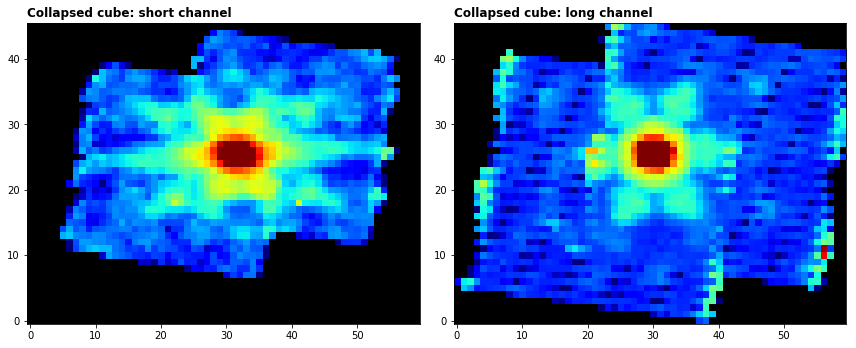

In [18]:
cube_file = glob.glob(os.path.join(output_dir,"dither*s3d.fits"))[0]
cube_dm = datamodels.open(cube_file)
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(np.sum(cube_dm.data[100:300], axis=0), cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=100,vmax=5e4))
axs[0].annotate('Collapsed cube: short channel', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[0].set_facecolor('black')
axs[1].imshow(np.sum(cube_dm.data[1200:1400], axis=0), cmap='jet', interpolation='nearest', origin='lower', norm=LogNorm(vmin=400,vmax=5e4))
axs[1].annotate('Collapsed cube: long channel', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')
axs[1].set_facecolor('black')

plt.tight_layout()
plt.show()

#### plot the spectrum

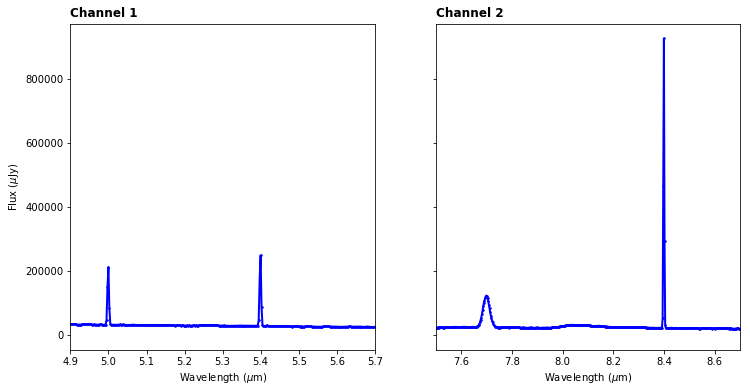

In [19]:
spec_file = glob.glob(os.path.join(output_dir,"dither_extract_1d.fits"))[0]
dm = datamodels.open(spec_file)

fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# plot the spectrum in the channel 2 wavelength range
spaxel_area = cube_dm.meta.wcsinfo.cdelt1 * cube_dm.meta.wcsinfo.cdelt2 * 3600**2
axs[0].plot(dm.spec[0].spec_table['WAVELENGTH'], dm.spec[0].spec_table['FLUX'] * spaxel_area, c='b', marker='.', markersize=3, linestyle='-', linewidth=2)
axs[0].set_ylabel(r'Flux ($\mu$Jy)')
axs[0].set_xlabel(r'Wavelength ($\mu$m)')
axs[0].set_xlim(4.9,5.7)
#axs[0].set_ylim(0,6000)
axs[0].annotate('Channel 1', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')


axs[1].plot(dm.spec[0].spec_table['WAVELENGTH'], dm.spec[0].spec_table['FLUX'] * spaxel_area, c='b', marker='.', markersize=3, linestyle='-', linewidth=2)
axs[1].set_xlabel(r'Wavelength ($\mu$m)')
axs[1].set_xlim(7.5,8.7)
axs[1].annotate('Channel 2', xy=(0.0, 1.02), xycoords='axes fraction', fontsize=12, fontweight='bold', color='k')


plt.show()